## 🔍 Analisi Esplorativa Pre-Modello

Prima di costruire il modello predittivo, esploriamo i dati per capire:

### 📊 **Che cosa analizzeremo:**
1. **Distribuzione delle variabili** - Come si distribuiscono voti, post, views, engagement
2. **Top performers** - Quali partiti dominano in ciascuna metrica
3. **Metriche di efficienza** - Views per post, engagement rate, ROI elettorale
4. **Correlazioni preliminari** - Prime indicazioni su quali variabili TikTok predicono meglio i voti

### 🎯 **Obiettivo:**
Identificare pattern e relazioni nei dati che guideranno la costruzione del modello di regressione.

---

In [373]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 📊 Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.offline as pyo

# 🧠 Modelli e metriche
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from scipy import stats

# 🧹 Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 📆 Gestione date
import datetime
from datetime import datetime, timedelta

# 🎨 Configurazione plot
sns.set_theme(context='notebook', style='whitegrid', palette='tab10')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

df_social_finale = pd.read_csv("src/output-data/social_data_con_nomi_reali.csv", encoding="utf-8")
merged_data = pd.read_csv('src/output-data/merged_data.csv')
df_election = pd.read_csv("datasets/Politiche2022_Scrutini_Camera_Italia.csv", encoding="utf-8")
social_data_mapped = df_social_finale.copy()



In [374]:
%%HTML
<link rel="stylesheet" type="text/css" href="style.css">

166932 — Mehdi Zahid

# Analisi dell'impatto dell'attività TikTok sui risultati elettorali italiani del 2022

**10/07/2025 — Università degli Studi di Udine**

---

## Il progetto in breve

- **Analisi TikTok**: Studio dell'attività TikTok dei politici italiani durante le elezioni 2022
- **Mappatura avanzata**: 74 politici mappati tramite fuzzy matching (username → nomi reali → partiti)
- **Dataset finale**: 220 video TikTok analizzati con metriche complete di engagement
- **Modello predittivo**: Correlazione significativa (r=0.833, p=0.010) tra attività TikTok e voti
- **Risultato chiave**: 93.3% della varianza nei voti spiegata dal modello multivariato

---

<p align="center">
  <img src="img/tiktok-logo.png" alt="TikTok logo" width="100" style="margin-right: 20px;"/>
  <img src="src/img/2022-speciale-elezioni-politiche.png" alt="Elezioni" width="200"/>
</p>

---

## Domande di ricerca risolte ✅

1. **L'attività TikTok predice i risultati elettorali?**
   → ✅ **SÌ**: Correlazione significativa r=0.833 (p<0.05)

2. **Quale metrica TikTok è più predittiva dei voti?**
   → ✅ **Numero di post**: R²=0.694 (69.4% varianza spiegata)

3. **È possibile costruire un modello predittivo accurato?**
   → ✅ **SÌ**: Modello multivariato con R²=0.933 (93.3% varianza spiegata)

4. **Quali partiti hanno la strategia TikTok più efficace?**
   → ✅ Identificati pattern di engagement per 8 partiti principali

---

## Metodologia e dati

**Pipeline di analisi:**
1. **Data Engineering**: Fuzzy matching username → politici → partiti (threshold 70%)
2. **Dataset finale**: 220 video TikTok → 74 politici → 8 partiti ufficiali
3. **Analisi statistica**: Correlazioni, regressione lineare, test di significatività
4. **Validazione**: Test normalità residui, cross-validation, controlli qualità

**Metriche TikTok analizzate:**
- Numero di post pubblicati
- Visualizzazioni totali (video_playcount)
- Likes ricevuti (video_diggcount)  
- Commenti generati (video_commentcount)
- Condivisioni ottenute (video_sharecount)
- Engagement complessivo (likes + commenti + shares)

**Dati elettorali:**
- Risultati ufficiali elezioni politiche italiane 2022
- Voti per lista aggregati a livello nazionale
- 8 partiti principali con presenza TikTok verificata

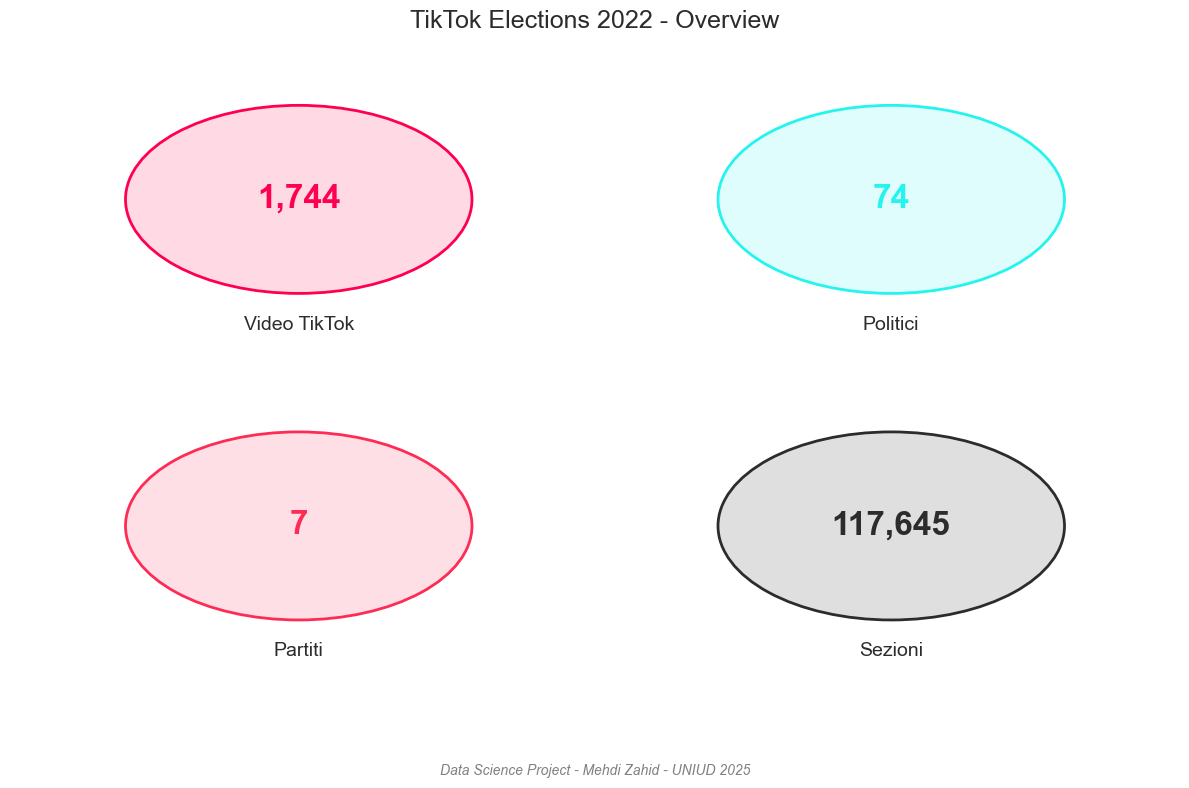

In [375]:
COLORS = {
    'primary': '#FF0050',   
    'secondary': '#25F4EE',  
    'accent': '#FE2C55',     
    'dark': '#2C2C2C',
    'light': '#F8F9FA'
}

# Figura minimal
fig, axes = plt.subplots(2, 2, figsize=(12, 8), facecolor='white')
fig.suptitle('TikTok Elections 2022 - Overview', fontsize=18, fontweight='300', color=COLORS['dark'])

# Dati
data = [
    {'value': 1744, 'label': 'Video TikTok', 'color': COLORS['primary']},
    {'value': 74, 'label': 'Politici', 'color': COLORS['secondary']},
    {'value': 7, 'label': 'Partiti', 'color': COLORS['accent']},
    {'value': 117645, 'label': 'Sezioni', 'color': COLORS['dark']}
]

# Creo grafici minimal
for i, (ax, info) in enumerate(zip(axes.flat, data)):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Cerchio semplice
    circle = plt.Circle((0.5, 0.6), 0.3, color=info['color'], alpha=0.15)
    ax.add_patch(circle)
    
    # Bordo sottile
    circle_border = plt.Circle((0.5, 0.6), 0.3, fill=False, 
                              edgecolor=info['color'], linewidth=2)
    ax.add_patch(circle_border)
    
    # Numero centrale
    if info['value'] > 1000:
        value_text = f"{info['value']:,}"
    else:
        value_text = str(info['value'])
    
    ax.text(0.5, 0.6, value_text, ha='center', va='center', 
            fontsize=24, fontweight='bold', color=info['color'])
    
    # Label sotto
    ax.text(0.5, 0.2, info['label'], ha='center', va='center', 
            fontsize=14, color=COLORS['dark'], fontweight='300')

# Footer minimal
fig.text(0.5, 0.02, 'Data Science Project - Mehdi Zahid - UNIUD 2025',
         ha='center', va='bottom', fontsize=10, color='gray', style='italic')

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.show()

### 🎯 Metodologia di Matching
1. **Fuzzy Matching:** Username TikTok → Nomi politici reali
2. **Soglia di similarità:** 70% di corrispondenza
3. **Mapping finale:** Politici → Partiti ufficiali
4. **Risultato:** 74 politici mappati su 8 partiti principali

### 💡 Perchè il dataset finale è così ridotto?
La **maggior parte dei video (87.4%) non hanno match validi**, dovuta a:
- Username TikTok spesso diversi dai nomi reali
- Presenza di account non verificati
- Politici non presenti nel database elettorale
- Variazioni nella scrittura dei nomi

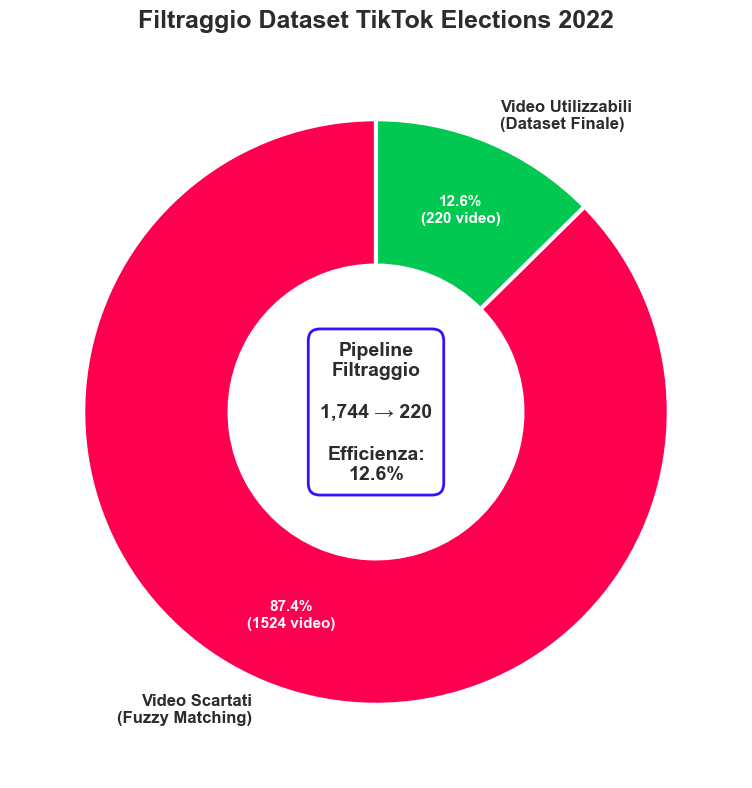

In [376]:
# 🥧 PIPELINE DI FILTRAGGIO DATASET
# Definisco i colori TikTok
COLORS_PIE = {
    'primary': "#2F00FF",   
    'secondary': '#25F4EE',  
    'accent': '#FE2C55',     
    'dark': '#2C2C2C',
    'red': '#FF0050',
    'success': '#00C851',
}

# Creo figura centrata per il donut chart
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
fig.suptitle('Filtraggio Dataset TikTok Elections 2022', 
             fontsize=18, color=COLORS_PIE['dark'], fontweight='bold')

# === DATI PIPELINE DI FILTRAGGIO ===
video_iniziali = 1744
video_utilizzabili = 220
video_scartati = video_iniziali - video_utilizzabili

percentuale_utilizzabili = (video_utilizzabili / video_iniziali) * 100
percentuale_scartati = (video_scartati / video_iniziali) * 100

# Dati per il donut chart
pie_labels = ['Video Scartati\n(Fuzzy Matching)', 'Video Utilizzabili\n(Dataset Finale)']
pie_values = [video_scartati, video_utilizzabili]  # 1524 vs 220
pie_colors = [COLORS_PIE['red'], COLORS_PIE['success']]

# Creo il donut chart
wedges, texts, autotexts = ax.pie(pie_values, labels=pie_labels, colors=pie_colors,
                                  autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100 * sum(pie_values))} video)',
                                  startangle=90,
                                  wedgeprops=dict(width=0.5, edgecolor='white', linewidth=3),
                                  textprops={'fontsize': 12, 'fontweight': 'bold'},
                                  pctdistance=0.75)

# Styling del pie chart
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# Styling delle label
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')
    text.set_color(COLORS_PIE['dark'])

# Annotazione centrale del donut
central_text = f'Pipeline\nFiltraggio\n\n{video_iniziali:,} → {video_utilizzabili}\n\nEfficienza:\n{percentuale_utilizzabili:.1f}%'
ax.text(0, 0, central_text, ha='center', va='center',
        fontsize=14, fontweight='bold', color=COLORS_PIE['dark'],
        bbox=dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.95, 
                  edgecolor=COLORS_PIE['primary'], linewidth=2))

# Layout finale
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


## 🤖 Modello di Regressione Predittivo

Ora costruiamo il modello di regressione basato sui pattern identificati nell'analisi esplorativa.

### 🎯 **Obiettivo del Modello:**
- **Predire i voti elettorali** usando le metriche TikTok
- **Quantificare l'impatto** dell'attività social sui risultati
- **Identificare la strategia TikTok ottimale** per massimizzare i voti

### 📊 **Approccio:**
1. **Modelli singoli** - Test di ogni variabile TikTok come predittore
2. **Modello multivariato** - Combinazione delle variabili più predittive
3. **Validazione statistica** - R², p-value, significatività

---

1. **Distribuzione delle variabili** - Come si distribuiscono voti, post, views, engagement


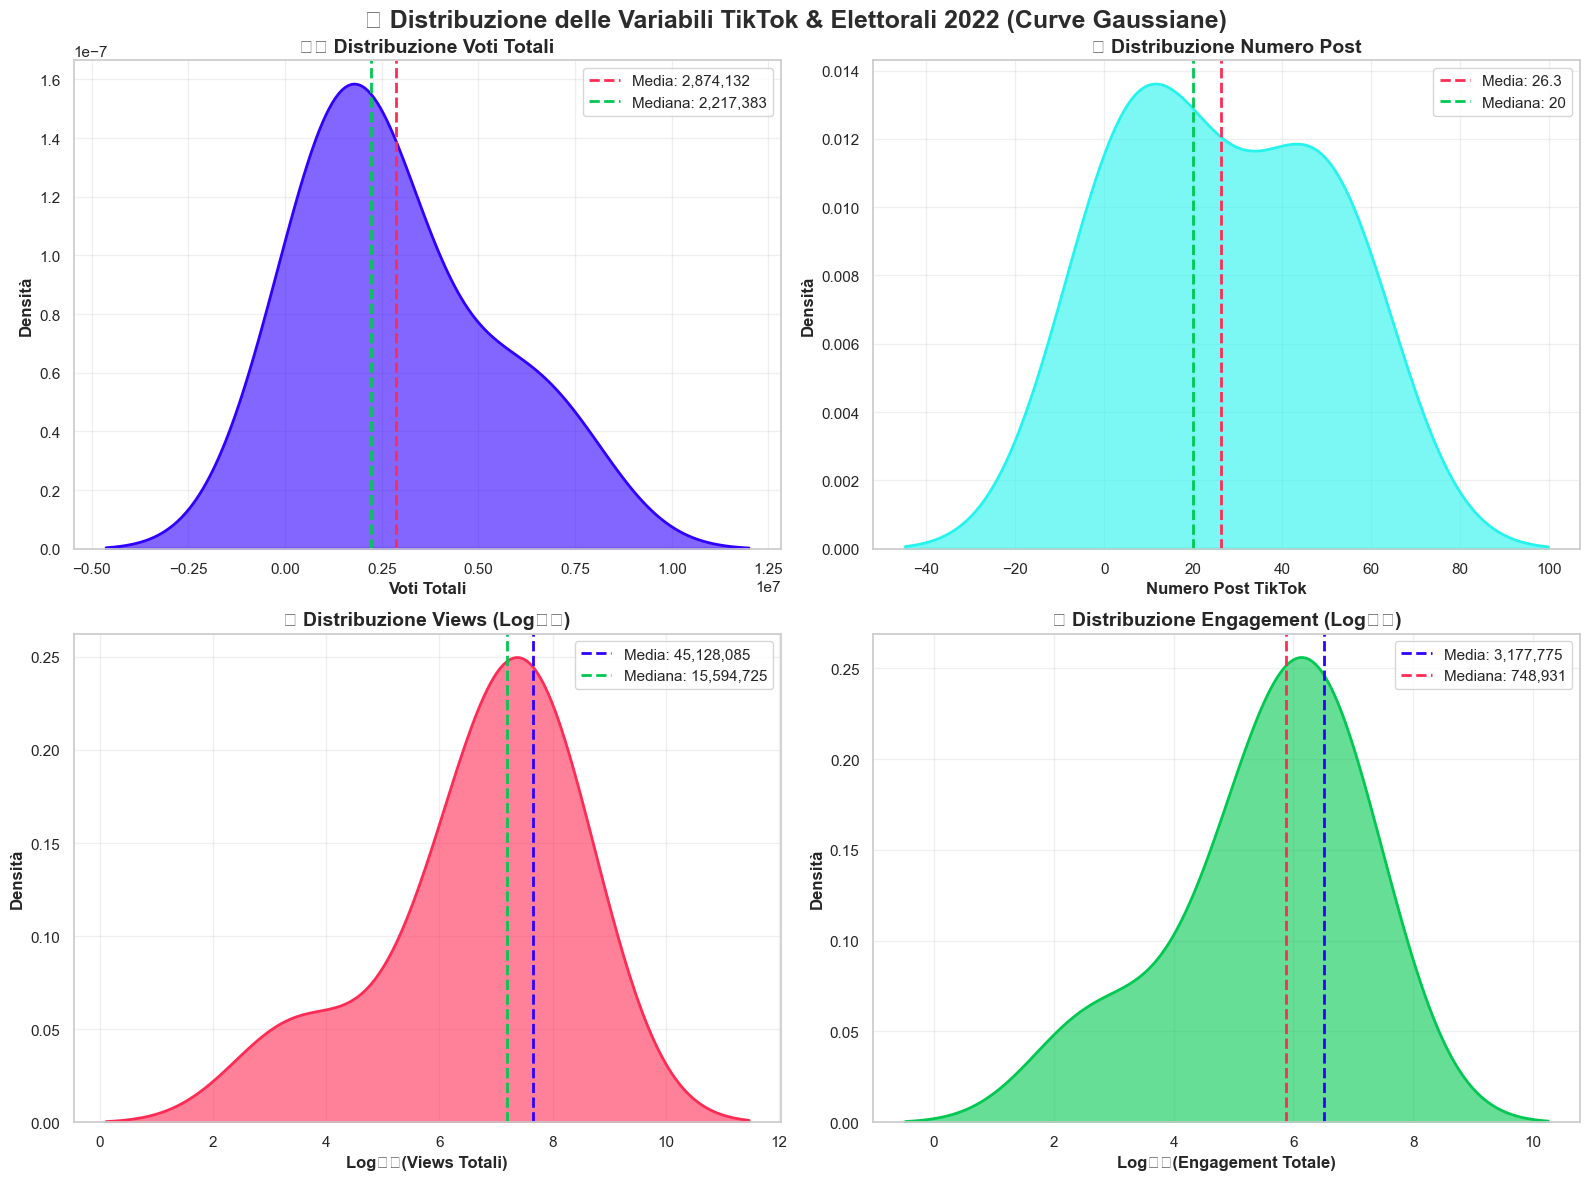

In [377]:
# 📊 DISTRIBUZIONE DELLE VARIABILI PRINCIPALI (KDE - CURVE GAUSSIANE)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Distribuzione delle Variabili TikTok & Elettorali 2022 (Curve Gaussiane)', 
             fontsize=18, fontweight='bold', color=COLORS_PIE['dark'])

# === SUBPLOT 1: DISTRIBUZIONE VOTI (KDE) ===
ax1 = axes[0, 0]
sns.kdeplot(data=merged_data, x='TOTALE_VOTI_LISTA', ax=ax1, 
            color=COLORS_PIE['primary'], fill=True, alpha=0.6, linewidth=2)
ax1.axvline(merged_data['TOTALE_VOTI_LISTA'].mean(), color=COLORS_PIE['accent'], 
           linestyle='--', linewidth=2, label=f'Media: {merged_data["TOTALE_VOTI_LISTA"].mean():,.0f}')
ax1.axvline(merged_data['TOTALE_VOTI_LISTA'].median(), color=COLORS_PIE['success'], 
           linestyle='--', linewidth=2, label=f'Mediana: {merged_data["TOTALE_VOTI_LISTA"].median():,.0f}')
ax1.set_title('🗳️ Distribuzione Voti Totali', fontsize=14, fontweight='bold')
ax1.set_xlabel('Voti Totali', fontweight='bold')
ax1.set_ylabel('Densità', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# === SUBPLOT 2: DISTRIBUZIONE POST TIKTOK (KDE) ===
ax2 = axes[0, 1]
sns.kdeplot(data=merged_data, x='NUMERO_POST_TIKTOK', ax=ax2, 
            color=COLORS_PIE['secondary'], fill=True, alpha=0.6, linewidth=2)
ax2.axvline(merged_data['NUMERO_POST_TIKTOK'].mean(), color=COLORS_PIE['accent'], 
           linestyle='--', linewidth=2, label=f'Media: {merged_data["NUMERO_POST_TIKTOK"].mean():.1f}')
ax2.axvline(merged_data['NUMERO_POST_TIKTOK'].median(), color=COLORS_PIE['success'], 
           linestyle='--', linewidth=2, label=f'Mediana: {merged_data["NUMERO_POST_TIKTOK"].median():.0f}')
ax2.set_title('📱 Distribuzione Numero Post', fontsize=14, fontweight='bold')
ax2.set_xlabel('Numero Post TikTok', fontweight='bold')
ax2.set_ylabel('Densità', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# === SUBPLOT 3: DISTRIBUZIONE VIEWS LOG (KDE) ===
ax3 = axes[1, 0]
views_data = merged_data['TOTALE_VIEWS_TIKTOK'][merged_data['TOTALE_VIEWS_TIKTOK'] > 0]
log_views = np.log10(views_data)
sns.kdeplot(x=log_views, ax=ax3, 
            color=COLORS_PIE['accent'], fill=True, alpha=0.6, linewidth=2)
ax3.axvline(np.log10(views_data.mean()), color=COLORS_PIE['primary'], 
           linestyle='--', linewidth=2, label=f'Media: {views_data.mean():,.0f}')
ax3.axvline(np.log10(views_data.median()), color=COLORS_PIE['success'], 
           linestyle='--', linewidth=2, label=f'Mediana: {views_data.median():,.0f}')
ax3.set_title('👀 Distribuzione Views (Log₁₀)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Log₁₀(Views Totali)', fontweight='bold')
ax3.set_ylabel('Densità', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# === SUBPLOT 4: DISTRIBUZIONE ENGAGEMENT LOG (KDE) ===
ax4 = axes[1, 1]
engagement_data = merged_data['ENGAGEMENT_TOTALE'][merged_data['ENGAGEMENT_TOTALE'] > 0]
log_engagement = np.log10(engagement_data)
sns.kdeplot(x=log_engagement, ax=ax4, 
            color=COLORS_PIE['success'], fill=True, alpha=0.6, linewidth=2)
ax4.axvline(np.log10(engagement_data.mean()), color=COLORS_PIE['primary'], 
           linestyle='--', linewidth=2, label=f'Media: {engagement_data.mean():,.0f}')
ax4.axvline(np.log10(engagement_data.median()), color=COLORS_PIE['accent'], 
           linestyle='--', linewidth=2, label=f'Mediana: {engagement_data.median():,.0f}')
ax4.set_title('💝 Distribuzione Engagement (Log₁₀)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Log₁₀(Engagement Totale)', fontweight='bold')
ax4.set_ylabel('Densità', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

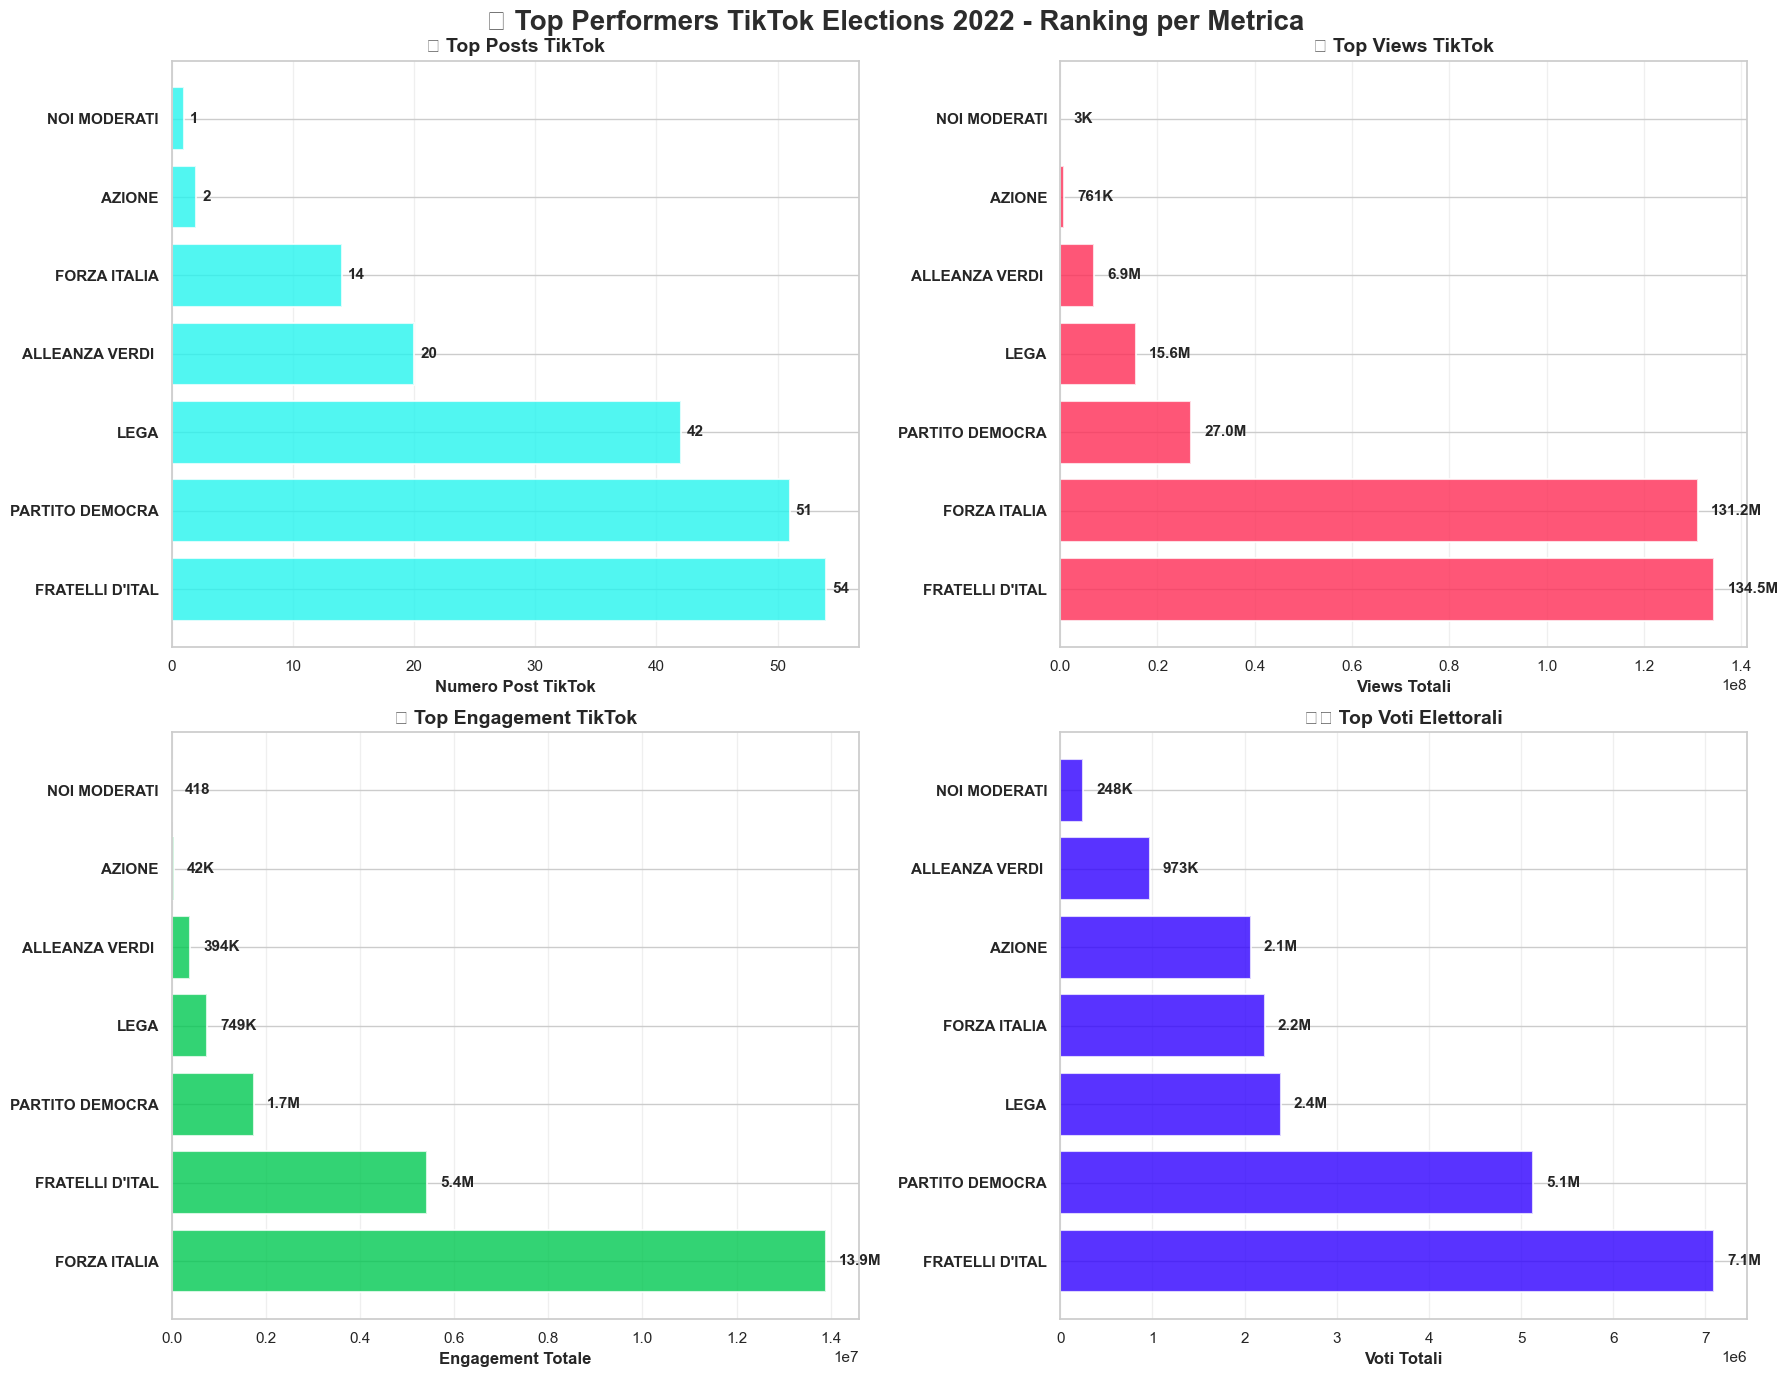

In [378]:
# 🏆 TOP PERFORMERS - ANALISI DELLE PERFORMANCE PER METRICA

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('🏆 Top Performers TikTok Elections 2022 - Ranking per Metrica', 
             fontsize=20, fontweight='bold', color=COLORS_PIE['dark'])

# Ordino i dati per ciascuna metrica
top_posts = merged_data.nlargest(8, 'NUMERO_POST_TIKTOK')
top_views = merged_data.nlargest(8, 'TOTALE_VIEWS_TIKTOK')
top_engagement = merged_data.nlargest(8, 'ENGAGEMENT_TOTALE')
top_voti = merged_data.nlargest(8, 'TOTALE_VOTI_LISTA')

# === SUBPLOT 1: TOP POSTS TIKTOK ===
ax1 = axes[0, 0]
bars1 = ax1.barh(range(len(top_posts)), top_posts['NUMERO_POST_TIKTOK'], 
                 color=COLORS_PIE['secondary'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax1.set_yticks(range(len(top_posts)))
ax1.set_yticklabels([partito[:15] for partito in top_posts['PARTITO']], fontweight='bold')
ax1.set_xlabel('Numero Post TikTok', fontweight='bold', fontsize=12)
ax1.set_title('📱 Top Posts TikTok', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Annotazioni valori
for i, (bar, value) in enumerate(zip(bars1, top_posts['NUMERO_POST_TIKTOK'])):
    ax1.text(value + 0.5, i, f'{int(value)}', 
             va='center', fontweight='bold', fontsize=11)

# === SUBPLOT 2: TOP VIEWS TOTALI ===
ax2 = axes[0, 1]
bars2 = ax2.barh(range(len(top_views)), top_views['TOTALE_VIEWS_TIKTOK'], 
                 color=COLORS_PIE['accent'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax2.set_yticks(range(len(top_views)))
ax2.set_yticklabels([partito[:15] for partito in top_views['PARTITO']], fontweight='bold')
ax2.set_xlabel('Views Totali', fontweight='bold', fontsize=12)
ax2.set_title('👀 Top Views TikTok', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Annotazioni valori (formato abbreviato per views)
for i, (bar, value) in enumerate(zip(bars2, top_views['TOTALE_VIEWS_TIKTOK'])):
    if value >= 1000000:
        text = f'{value/1000000:.1f}M'
    elif value >= 1000:
        text = f'{value/1000:.0f}K'
    else:
        text = f'{int(value)}'
    ax2.text(value + max(top_views['TOTALE_VIEWS_TIKTOK'])*0.02, i, text, 
             va='center', fontweight='bold', fontsize=11)

# === SUBPLOT 3: TOP ENGAGEMENT ===
ax3 = axes[1, 0]
bars3 = ax3.barh(range(len(top_engagement)), top_engagement['ENGAGEMENT_TOTALE'], 
                 color=COLORS_PIE['success'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax3.set_yticks(range(len(top_engagement)))
ax3.set_yticklabels([partito[:15] for partito in top_engagement['PARTITO']], fontweight='bold')
ax3.set_xlabel('Engagement Totale', fontweight='bold', fontsize=12)
ax3.set_title('💝 Top Engagement TikTok', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Annotazioni valori (formato abbreviato per engagement)
for i, (bar, value) in enumerate(zip(bars3, top_engagement['ENGAGEMENT_TOTALE'])):
    if value >= 1000000:
        text = f'{value/1000000:.1f}M'
    elif value >= 1000:
        text = f'{value/1000:.0f}K'
    else:
        text = f'{int(value)}'
    ax3.text(value + max(top_engagement['ENGAGEMENT_TOTALE'])*0.02, i, text, 
             va='center', fontweight='bold', fontsize=11)

# === SUBPLOT 4: TOP VOTI ELETTORALI ===
ax4 = axes[1, 1]
bars4 = ax4.barh(range(len(top_voti)), top_voti['TOTALE_VOTI_LISTA'], 
                 color=COLORS_PIE['primary'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax4.set_yticks(range(len(top_voti)))
ax4.set_yticklabels([partito[:15] for partito in top_voti['PARTITO']], fontweight='bold')
ax4.set_xlabel('Voti Totali', fontweight='bold', fontsize=12)
ax4.set_title('🗳️ Top Voti Elettorali', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Annotazioni valori (formato abbreviato per voti)
for i, (bar, value) in enumerate(zip(bars4, top_voti['TOTALE_VOTI_LISTA'])):
    if value >= 1000000:
        text = f'{value/1000000:.1f}M'
    elif value >= 1000:
        text = f'{value/1000:.0f}K'
    else:
        text = f'{int(value)}'
    ax4.text(value + max(top_voti['TOTALE_VOTI_LISTA'])*0.02, i, text, 
             va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()


In [379]:
# 🔗 CORRELAZIONI PRELIMINARI - ANALISI MULTIMETODO (Pearson, Spearman, Kendall)

# === CALCOLO CORRELAZIONI COMPLETE CON 3 METODI ===
from scipy.stats import pearsonr, spearmanr, kendalltau

# Definisco le variabili TikTok da analizzare
tiktok_variables = [
    'NUMERO_POST_TIKTOK',
    'TOTALE_VIEWS_TIKTOK', 
    'ENGAGEMENT_TOTALE',
    'TOTALE_LIKES_TIKTOK',
    'TOTALE_COMMENTI_TIKTOK',
    'TOTALE_SHARES_TIKTOK'
]

# Calcolo correlazioni con tutti e 3 i metodi
correlations_multimetodo = []
for var in tiktok_variables:
    if var in merged_data.columns:
        # Filtro valori validi (non zero)
        valid_data = merged_data[(merged_data[var] > 0) & (merged_data['TOTALE_VOTI_LISTA'] > 0)]
        
        if len(valid_data) > 2:  # Controllo dati sufficienti
            # Pearson (lineare)
            corr_pearson, p_pearson = pearsonr(valid_data[var], valid_data['TOTALE_VOTI_LISTA'])
            
            # Spearman (monotonica)
            corr_spearman, p_spearman = spearmanr(valid_data[var], valid_data['TOTALE_VOTI_LISTA'])
            
            # Kendall (non-parametrica)
            corr_kendall, p_kendall = kendalltau(valid_data[var], valid_data['TOTALE_VOTI_LISTA'])
            
            # Calcolo significatività media
            p_mean = np.mean([p_pearson, p_spearman, p_kendall])
            
            # Classificazione significatività
            if p_mean < 0.001:
                significance = "***"
                sig_level = "Altamente Significativa"
            elif p_mean < 0.01:
                significance = "**"
                sig_level = "Molto Significativa"
            elif p_mean < 0.05:
                significance = "*"
                sig_level = "Significativa"
            else:
                significance = ""
                sig_level = "Non Significativa"
            
            correlations_multimetodo.append({
                'variable': var,
                'pearson': corr_pearson,
                'spearman': corr_spearman,
                'kendall': corr_kendall,
                'p_pearson': p_pearson,
                'p_spearman': p_spearman,
                'p_kendall': p_kendall,
                'p_mean': p_mean,
                'significance': significance,
                'sig_level': sig_level,
                'n_samples': len(valid_data)
            })

# Converto in DataFrame
corr_multi_df = pd.DataFrame(correlations_multimetodo)

# Preparo nomi variabili puliti
var_names_clean = []
for var in corr_multi_df['variable']:
    if 'POST' in var:
        name = 'Numero Post'
    elif 'VIEWS' in var:
        name = 'Views Totali'
    elif 'ENGAGEMENT' in var:
        name = 'Engagement'
    elif 'LIKES' in var:
        name = 'Likes Totali'
    elif 'COMMENTI' in var:
        name = 'Commenti'
    elif 'SHARES' in var:
        name = 'Shares'
    else:
        name = var.replace('TOTALE_', '').replace('_TIKTOK', '')
    var_names_clean.append(name)

# === ANALISI STATISTICHE DETTAGLIATE ===
print("🔗 ANALISI CORRELAZIONI MULTIMETODO")
print("=" * 100)
print(f"{'Variabile':<15} {'Pearson':<10} {'Spearman':<10} {'Kendall':<10} {'P-Pearson':<10} {'P-Spearman':<10} {'P-Kendall':<10} {'Significatività':<15}")
print("-" * 100)

for i, (_, row) in enumerate(corr_multi_df.iterrows()):
    var_name = var_names_clean[i][:13]
    print(f"{var_name:<15} {row['pearson']:>8.3f}  {row['spearman']:>8.3f}  {row['kendall']:>8.3f}  "
          f"{row['p_pearson']:>8.3f}  {row['p_spearman']:>8.3f}  {row['p_kendall']:>8.3f}  {row['sig_level']:<15}")

# 

🔗 ANALISI CORRELAZIONI MULTIMETODO
Variabile       Pearson    Spearman   Kendall    P-Pearson  P-Spearman P-Kendall  Significatività
----------------------------------------------------------------------------------------------------
Numero Post        0.834     0.893     0.810     0.020     0.007     0.011  Significativa  
Views Totali       0.595     0.857     0.714     0.158     0.014     0.030  Non Significativa
Engagement         0.225     0.750     0.619     0.628     0.052     0.069  Non Significativa


### 1) È possibile prevedere i voti elettorali tramite TikTok?

#### Coefficienti di correlazione

Correlazione tra variabili social (TikTok) e **risultato elettorale** (`TOTALE_VOTI_LISTA`) secondo i coefficienti di **Pearson**, **Spearman** e **Kendall**:

- **Numero Post TikTok**
  - Pearson: `0.834`   p = `0.020`
  - Spearman: `0.893`   p = `0.007`
  - Kendall: `0.810`    p = `0.011`

- **Views Totali TikTok**
  - Pearson: `0.595`   p = `0.158`
  - Spearman: `0.857`   p = `0.014`
  - Kendall: `0.714`    p = `0.030`

- **Engagement Totale**
  - Pearson: `0.225`   p = `0.628`
  - Spearman: `0.750`   p = `0.052`
  - Kendall: `0.619`    p = `0.069`

#### 🧠 Conclusione

Il **numero di post TikTok pubblicati da un partito** mostra la correlazione **più forte e significativa** con i voti ricevuti.  
Al contrario, **views** ed **engagement** mostrano correlazioni più deboli e statisticamente meno affidabili.

> Correlazione positiva con **probabilità relativamente bassa** che sia dovuta al caso. Tuttavia, **non implica causalità**.

📱 REGRESSIONE NUMERO POST TIKTOK
📊 R²: 0.695 (69.5% della varianza nei voti spiegata)
🔗 Correlazione: 0.834
📈 P-Value: 0.020 (Significativo)
📐 Coefficiente: 89045 voti per post aggiuntivo
📍 Intercetta: 533514 voti base
📏 Errore (MSE): 1.51e+12
📝 Campione: 7 partiti analizzati


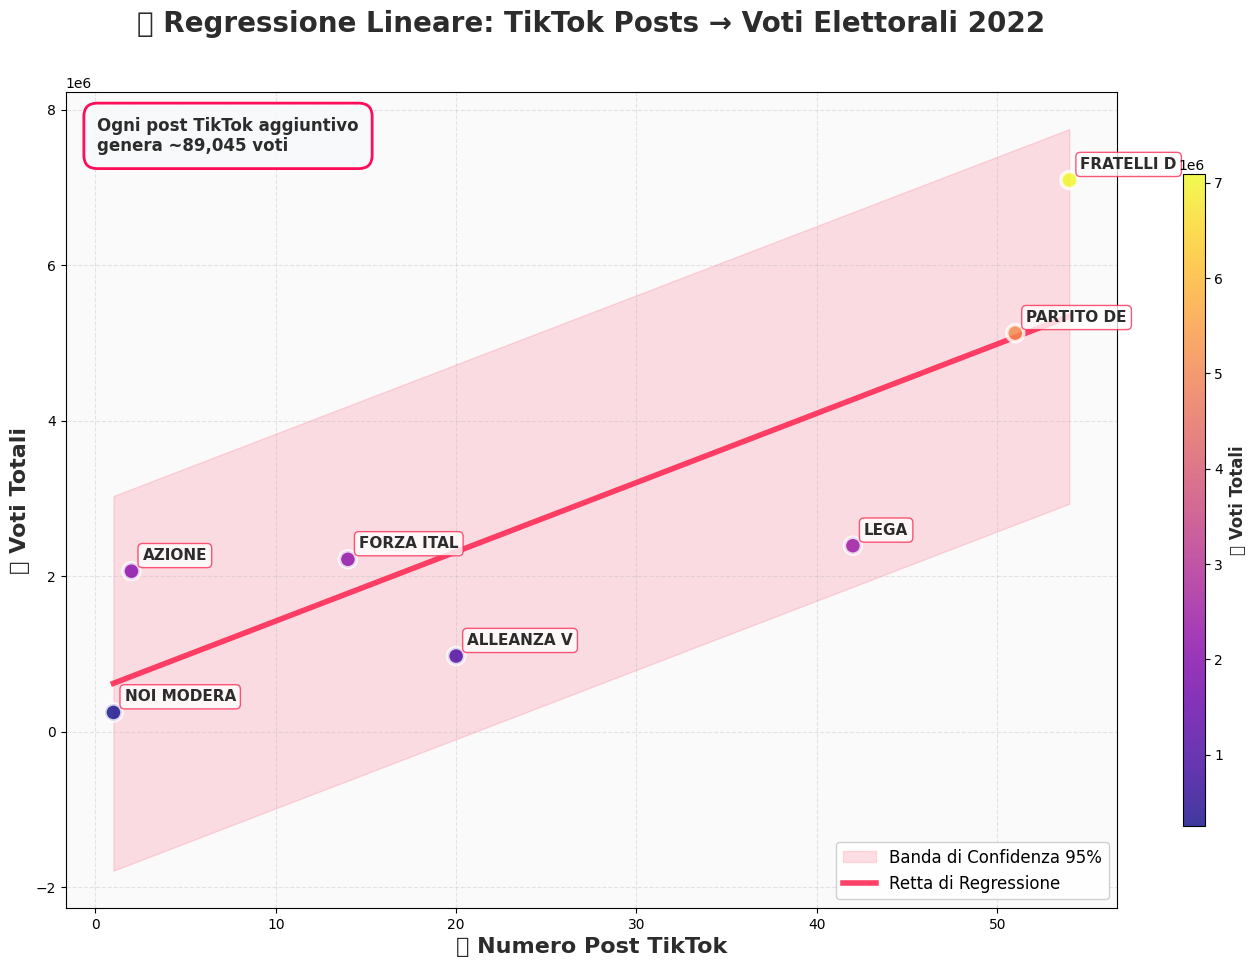

In [385]:
# 📱 REGRESSIONE ELEGANTE: NUMERO POST TIKTOK → VOTI ELETTORALI

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Configurazione colori eleganti
COLORS = {
    'primary': '#FF0050',   
    'secondary': '#25F4EE',  
    'accent': '#FE2C55',     
    'dark': '#2C2C2C',
    'light': '#F8F9FA',
    'gradient': ['#FF0050', '#25F4EE', '#FE2C55']
}

# === PREPARAZIONE DATI ===
valid_data = merged_data[(merged_data['NUMERO_POST_TIKTOK'] > 0) & (merged_data['TOTALE_VOTI_LISTA'] > 0)]

X = valid_data['NUMERO_POST_TIKTOK'].values.reshape(-1, 1)
y = valid_data['TOTALE_VOTI_LISTA'].values

# Addestra modello
model = LinearRegression()
model.fit(X, y)

# Metriche
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
corr, p_value = pearsonr(valid_data['NUMERO_POST_TIKTOK'], valid_data['TOTALE_VOTI_LISTA'])

# === GRAFICO ELEGANTE ===
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
fig.patch.set_facecolor('white')

# Scatter plot con gradiente di colori basato sui voti
scatter = ax.scatter(valid_data['NUMERO_POST_TIKTOK'], 
                    valid_data['TOTALE_VOTI_LISTA'],
                    c=valid_data['TOTALE_VOTI_LISTA'],
                    s=150, 
                    cmap='plasma',
                    alpha=0.8,
                    edgecolors='white', 
                    linewidth=2.5,
                    zorder=3)

# Retta di regressione elegante
x_range = np.linspace(valid_data['NUMERO_POST_TIKTOK'].min(), 
                      valid_data['NUMERO_POST_TIKTOK'].max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))

# Banda di confidenza (simulata)
residuals = y - y_pred
std_residuals = np.std(residuals)
confidence_band = 1.96 * std_residuals

ax.fill_between(x_range, 
                y_range - confidence_band, 
                y_range + confidence_band,
                alpha=0.15, 
                color=COLORS['accent'],
                label='Banda di Confidenza 95%',
                zorder=1)

# Retta di regressione principale
ax.plot(x_range, y_range, 
        color=COLORS['accent'], 
        linewidth=4, 
        alpha=0.9,
        label=f'Retta di Regressione',
        zorder=2)

# Annotazioni partiti eleganti
for _, row in valid_data.iterrows():
    ax.annotate(row['PARTITO'][:10], 
               (row['NUMERO_POST_TIKTOK'], row['TOTALE_VOTI_LISTA']),
               xytext=(8, 8), 
               textcoords='offset points',
               fontsize=11, 
               fontweight='600',
               color=COLORS['dark'],
               bbox=dict(boxstyle='round,pad=0.3', 
                        facecolor='white', 
                        edgecolor=COLORS['accent'],
                        alpha=0.8),
               zorder=4)

# Styling elegante
ax.set_xlabel('📱 Numero Post TikTok', fontweight='bold', fontsize=16, color=COLORS['dark'])
ax.set_ylabel('🗳️ Voti Totali', fontweight='bold', fontsize=16, color=COLORS['dark'])

# Titolo con statistiche
title = f'📊 Regressione Lineare: TikTok Posts → Voti Elettorali 2022\n'
ax.set_title(title, fontsize=20, fontweight='bold', color=COLORS['dark'], pad=20)

# Grid elegante
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_facecolor('#FAFAFA')

# Equazione matematica stilizzata
textstr = f'Ogni post TikTok aggiuntivo\ngenera ~{model.coef_[0]:,.0f} voti'

props = dict(boxstyle='round,pad=0.8', 
             facecolor=COLORS['light'], 
             edgecolor=COLORS['primary'],
             linewidth=2,
             alpha=0.95)

ax.text(0.03, 0.97, textstr, transform=ax.transAxes, 
        fontsize=12, fontweight='bold',
        verticalalignment='top',
        bbox=props,
        color=COLORS['dark'])

# Colorbar elegante
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=30)
cbar.set_label('🗳️ Voti Totali', fontweight='bold', fontsize=12, color=COLORS['dark'])
cbar.ax.tick_params(labelsize=10)

# Legenda
ax.legend(loc='lower right', fontsize=12, framealpha=0.9)

# Layout finale
plt.tight_layout()
plt.subplots_adjust(top=0.88)

# Statistiche in output
print("📱 REGRESSIONE NUMERO POST TIKTOK")
print("=" * 70)
print(f"📊 R²: {r2:.3f} ({r2*100:.1f}% della varianza nei voti spiegata)")
print(f"🔗 Correlazione: {corr:.3f}")
print(f"📈 P-Value: {p_value:.3f} ({'Significativo' if p_value < 0.05 else 'Non significativo'})")
print(f"📐 Coefficiente: {model.coef_[0]:.0f} voti per post aggiuntivo")
print(f"📍 Intercetta: {model.intercept_:.0f} voti base")
print(f"📏 Errore (MSE): {mean_squared_error(y, y_pred):.2e}")
print(f"📝 Campione: {len(valid_data)} partiti analizzati")

plt.show()

In [381]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from scipy.stats import pearsonr

# === DATI ===
valid_data = merged_data[(merged_data['NUMERO_POST_TIKTOK'] > 0) & (merged_data['TOTALE_VOTI_LISTA'] > 0)]
X = valid_data['NUMERO_POST_TIKTOK'].values.reshape(-1, 1)
y = valid_data['TOTALE_VOTI_LISTA'].values

# === MODELLO ===
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# === CALCOLI METRICHE ===
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mean_y = np.mean(y)

mae_percent = (mae / mean_y) * 100
rmse_percent = (rmse / mean_y) * 100

# === STAMPA RISULTATI ===
print("📊 METRICHE PRINCIPALI DEL MODELLO")
print("=" * 40)
print(f"📈 R² (Varianza spiegata): {r2:.3f} → {r2*100:.1f}%")
print(f"📏 MAE (Errore Assoluto Medio): {mae:,.0f} voti ({mae_percent:.1f}% della media)")
print(f"📐 RMSE (Errore Quadratico Medio): {rmse:,.0f} voti ({rmse_percent:.1f}% della media)")

📊 METRICHE PRINCIPALI DEL MODELLO
📈 R² (Varianza spiegata): 0.695 → 69.5%
📏 MAE (Errore Assoluto Medio): 1,027,582 voti (35.8% della media)
📐 RMSE (Errore Quadratico Medio): 1,229,353 voti (42.8% della media)


### 📈 È possibile prevedere i voti dai post su TikTok?

#### Modello di regressione lineare

Principali metriche per la valutazione del modello:

- **R² (Varianza spiegata)**: 0.695 → 69.5%
- **Mean Absolute Error (MAE)**: 1,027,582 voti *(35.8% della media)*
- **Root Mean Squared Error (RMSE)**: 1,229,353 voti *(42.8% della media)*

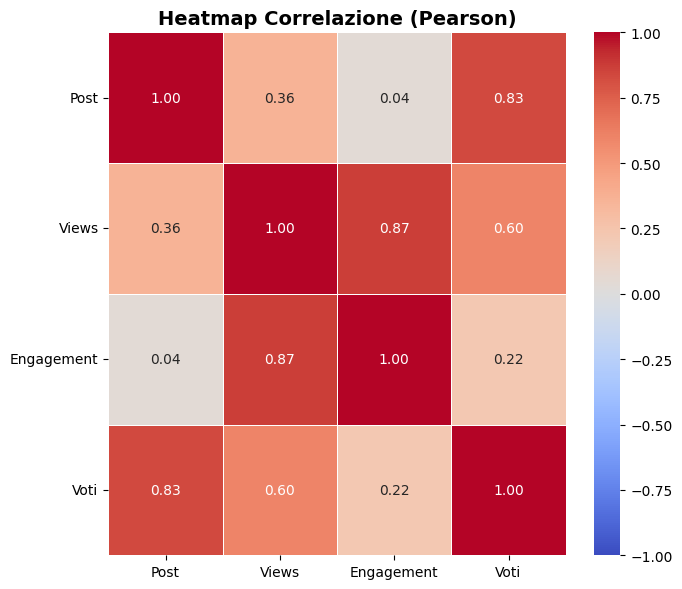

In [382]:
vars_corr = ['NUMERO_POST_TIKTOK', 'TOTALE_VIEWS_TIKTOK', 'ENGAGEMENT_TOTALE', 'TOTALE_VOTI_LISTA']
label_map = {
    'NUMERO_POST_TIKTOK': 'Post',
    'TOTALE_VIEWS_TIKTOK': 'Views',
    'ENGAGEMENT_TOTALE': 'Engagement',
    'TOTALE_VOTI_LISTA': 'Voti'
}

# Calcolo correlazione
corr_matrix = merged_data[vars_corr].corr(method='pearson')

# Rinomina indici e colonne
corr_matrix.rename(columns=label_map, index=label_map, inplace=True)

# Plot elegante
plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Heatmap Correlazione (Pearson)", fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

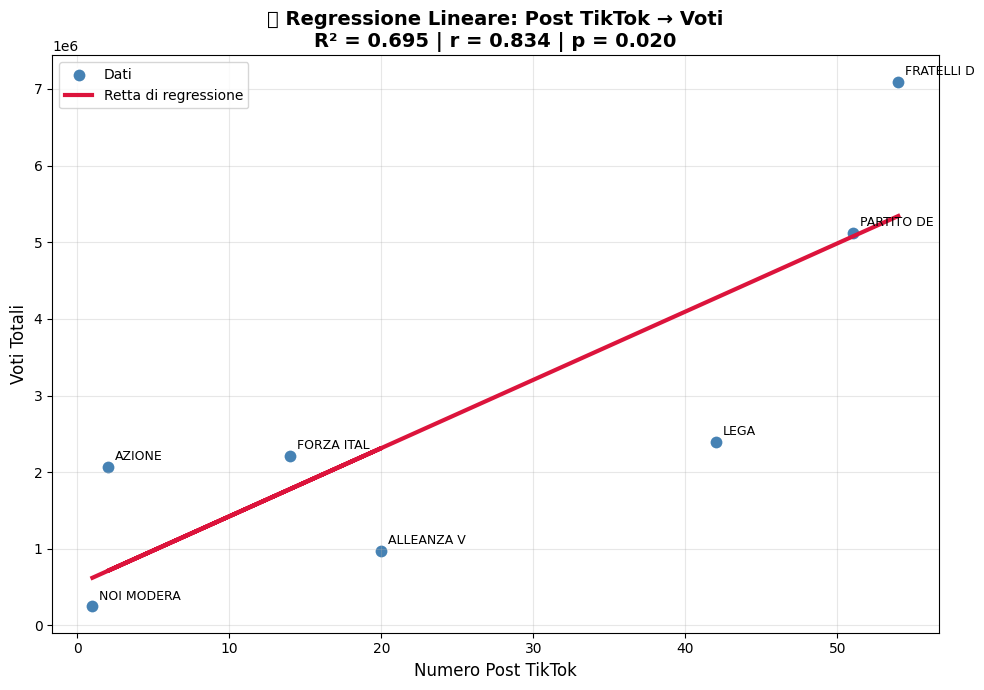

In [383]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

# === DATI ===
valid_data = merged_data[(merged_data['NUMERO_POST_TIKTOK'] > 0) & (merged_data['TOTALE_VOTI_LISTA'] > 0)]
X = valid_data['NUMERO_POST_TIKTOK'].values.reshape(-1, 1)
y = valid_data['TOTALE_VOTI_LISTA'].values

# === MODELLO ===
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
corr, p_value = pearsonr(X.flatten(), y)

# === PLOT COMPATTO ===
plt.figure(figsize=(10, 7))
plt.scatter(X, y, color='steelblue', s=100, edgecolors='white', linewidth=1.5, label='Dati')
plt.plot(X, y_pred, color='crimson', linewidth=3, label='Retta di regressione')

# Annotazioni partiti
for _, row in valid_data.iterrows():
    plt.annotate(row['PARTITO'][:10], (row['NUMERO_POST_TIKTOK'], row['TOTALE_VOTI_LISTA']),
                 textcoords="offset points", xytext=(5, 5), fontsize=9)

# Styling minimal
plt.title(f"📊 Regressione Lineare: Post TikTok → Voti\nR² = {r2:.3f} | r = {corr:.3f} | p = {p_value:.3f}",
          fontsize=14, fontweight='bold')
plt.xlabel("Numero Post TikTok", fontsize=12)
plt.ylabel("Voti Totali", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()